<img src='../img/EUMETSAT_Logo.png' alt='Logo EUMETSAT' align='right' width='30%'></img>

<br>

<a href="../00_index.ipynb"><< Index</a><br>

<div class="alert alert-block alert-success">
<b>20 - DATA CUBE</b></div>

<hr>

# Learning module for the Data Tailor Atmospheric Composition Data Cube 

This is a Python-based training module presenting how to use the **EUMETSAT Atmospheric Composition Data Cube** (ACDC) plugin for the **EUMETSAT Data Tailor** to work with satellite-derived geophysical variables relevant for atmospheric monitoring.

## Introduction

The **Data Tailor ACDC plugin** simplifies the process to manipulate data and thus visualise the datasets on maps.
Specifically, the plugin features the following functionalities:
* it downloads the desired data from the reference website
* it allows cropping a region of interest (ROI) 
* it allows defining a filter to save only the variables of interest (layer filter)
* it allows defining the time coverage of the dataset (accordigly to the available input data)
* it converts input products to NetCDF format compliant with CF-conventions and Climate Data Store ([CDS](https://cds.climate.copernicus.eu)) Common Data Model with coordinates dimensions
* it allows time aggregation returning a single dataset
* it estimates the output products size in advance.

This notebook presents an example on how to obtain customised *GOME-2 Metop-A Level 3 Nitrogen Dioxide (NO2)* data using the Data Tailor interface. 

In this tutorial **you will learn how to use the following ACDC plugin features**:
* retrieve the list of supported products
* define the configuration to obtain the GOME-2 Metop-A data specifying
    * a time period
    * a region of interest
    * a layer filter
    * time aggregation
* estimate the output dataset size
* invoke the Data Tailor interface
* generate the output dataset in NetCDF format.

With the output products, you will:
* visualise data on a `2D Map`
* save the dataset locally

This notebook is designed for *medium-level* users with basic knowledge about Python and Atmospheric composition data.

### Module outline:
* [1 - Obtain NO<sub>2</sub> data using the *Atmospheric Composition Data Cube* plugin](#Obtain-NO2-data-using-the-Atmospheric-Composition-Data-Cube-plugin)
* [2 - Explore the output dataset](#Explore-the-output-dataset)
* [3 - Visualise `no2_total` data](#Visualise-no2_total-data)
* [4 - Save the data cube locally](#Save-the-data-cube-locally) 

<hr>

### Load required external libraries

In [29]:
import os
from pathlib import Path
import xarray as xr

from matplotlib import pyplot as plt

In [30]:
os.environ['PATH'] = f"/opt/conda/envs/acdc-training/bin/:{os.environ['PATH']}"

In [31]:
# Load auxiliary functions
%run ../functions.ipynb

## Obtain NO<sub>2</sub> data using the *Atmospheric Composition Data Cube* plugin

To use the functionalities of the ACDC plugin, you only need to import the **Data Tailor API**.

In [32]:
from epct import api 

### Define the Data Tailor configuration

This section presents an example on how to define valid Data Tailor configurations to obtain the products you want to be included in your data cube.

Let's start visualising the supported satellite products and how to specify them in the Data Tailor interface. 

#### Select the satellite products

In the Data Tailor API interface, a target product is referred to as a specific *product-id*. 

To discover which products are supported by the ACDC plugin and their corresponding *product_id*, you can use the *Data Tailor API* `read` function specifying the `epct_acdc` backend, as shown below.


**Note**: see [Index notebook](../00_index.ipynb) to obtain also the data web-provider of each product in a "fancy" print. 

In [33]:
# Obtain the dictionary of supported products
products = api.read("products", backend="epct_acdc")

# The product_ids are the keys of the dictionary 
for key, value in products.items():
    print(value["name"])
    print('product-id:', key, '\n')

GOME-2 Metop-A Level 3 Absorbing Aerosol Index (AAI)
product-id: GOME2_METOPA_AAI 

GOME Metop-A Level 3 Tropospheric Formaldehyde (HCHO)
product-id: GOME2_METOPA_HCHO 

GOME-2 Metop-A Level 3 Nitrogen Dioxide (NO2)
product-id: GOME2_METOPA_NO2 

GOME-2 Metop-B Level 3 Absorbing Aerosol Index (AAI)
product-id: GOME2_METOPB_AAI 

GOME Metop-B Level 3 Tropospheric Formaldehyde (HCHO)
product-id: GOME2_METOPB_HCHO 

GOME-2 Metop-B Level 3 Nitrogen Dioxide (NO2)
product-id: GOME2_METOPB_NO2 

GOME-2 Metop-B Level 3 Nitrogen Dioxide (NO2) - ASCII format
product-id: GOME2_METOPB_NO2_ASCII 

GOME-2 Metop-C Level 3 Absorbing Aerosol Index (AAI)
product-id: GOME2_METOPC_AAI 

IASI Metop-A Level 3 Carbon monoxide (CO)
product-id: IASIL3_METOPA_CO 

IASI Metop-A Level 3 Formic acid (HCOOH)
product-id: IASIL3_METOPA_HCOOH 

IASI Metop-A Level 3 Ammonia (NH3)
product-id: IASIL3_METOPA_NH3 

IASI Metop-B Level 3 Carbon monoxide (CO)
product-id: IASIL3_METOPB_CO 

IASI Metop-B Level 3 Formic acid (HC

From the above list, you can spot which is the product-id corresponding to the product you want to include in your data cube.

For this example, you will include `GOME2_METOPA_NO2` only in your data cube.

In [34]:
# Input products for Data Cube
product_id = 'GOME2_METOPA_NO2'

#### Define the time coverage

The time extent of temporal data is defined as the duration in time within which the data was collected.
As said, the time coverage and periodicity vary with the data records. 
To define a valid time period, you can obtain the available time coverage of products using the *Data Tailor API* function `config`.

Based on that, if you don't define a time interval, the plugin automatically retrieves all the time extent available for that product.
On the contrary, you can select a time subset defining the following variables:
* *sensing_start*: a date greater than or equal to the following "start-date"
* *sensing_stop*: a date equal to or smaller than the following "stop-date", if any

If "stop-time" is not defined for the current data, it means the product continues to be recorded.  

**Note**: dates must be defined in the following format: $$'<year><month><day>T000000Z'$$

In [35]:
# Discover the available temporal availability
config = api.config()

product_specs = config['backends_configurations']['epct_acdc']['INPUT_PRODUCTS'][product_id]
print(product_id)
print("periodicity: {}".format(product_specs['periodicity']))
print("start-date: {}".format(product_specs['start_date']))
if 'end_date' in product_specs:
    print("stop-date: {}".format(product_specs['end_date']))

GOME2_METOPA_NO2
periodicity: monthly
start-date: 20070201
stop-date: 20170831


For example, let's request the following time subset:

In [36]:
sensing_start = '20100101T000000Z'
sensing_stop  = '20100601T000000Z'

#### (Optional) Select the layer(s) of interest

Each product contains a list of layers. Using the Data Tailor interface, you can filter only the layer(s) you need.
If you don't define any filter, by default the Data Tailor ACDC plugin stores all the available variables in the output dataset.

Using the Data Tailor interface, you can select the layer of interest in two ways:
* applying a pre-defined layer(s) filter (the available filters are tailored to each specific product)
* defining a custom filter via a dictionary containing the key `bands`. 

Use the Data Tailor API `read` function to print the list of available variables. 
The following cell shows you how to print such list for the selected product.

In [37]:
# Define a printing function for the selected product available bands 
def print_product_layers(product_id):
    
    # Obtain the list of available bands
    products = api.read(f"products/{product_id}")
    layers=products['bands']
    # print the list
    print("{} layers: \n".format(product_id))
    for key, value in layers.items():  
         print("{}) {}: {}".format(value['number'], key, value['name']))
            
             

# Display the list calling the above printing function
print_product_layers(product_id)

GOME2_METOPA_NO2 layers: 

1) cloud_albedo: Average cloud albedo
2) cloud_albedo_std: Cloud albedo standard_deviation
3) cloud_fraction: Average cloud area fraction
4) cloud_fraction_std: Cloud area fraction standard deviation
5) cloud_height: Average cloud height
6) cloud_height_std: height at cloud top standard deviation
7) no2_total: Total Column NO2 content
8) no2_total_err: Error associated to total column NO2 content
9) no2_total_std: Total column NO2 standard deviation
10) no2_trop: Tropospheric column NO2 content
11) no2_trop_err: Error associated to tropospheric tolumn NO2 content
12) no2_trop_std: Tropospheric column NO2 standard deviation
13) nobs: Number of Observations
14) surface_albedo: Average surface area albedo
15) surface_flag: Average land sea flag
16) surface_height: Avearge surface area height [km]


As you can see, the *GOME2_METOPA_NO2* product contains sixteen variables. 

To see the available pre-defined filters for the current product, use again the API `read` function specifying, this time, the `"filters"` argument, as follows

In [38]:
filters = api.read("filters", product=product_id)
filters

{'gome2_metopa_no2_main': {'name': 'Main variables',
  'product': 'GOME2_METOPA_NO2',
  'bands': [{'name': 'Total Column NO2 content',
    'varname': 'NO2total',
    'number': 7,
    'id': 'no2_total'},
   {'name': 'Tropospheric column NO2 content',
    'varname': 'NO2trop',
    'number': 10,
    'id': 'no2_trop'}],
  'id': 'gome2_metopa_no2_main'},
 'gome2_metopa_no2_total': {'name': 'Total column data',
  'product': 'GOME2_METOPA_NO2',
  'bands': ['no2_total', 'no2_total_err', 'no2_total_std'],
  'id': 'gome2_metopa_no2_total'},
 'gome2_metopa_no2_tropo': {'name': 'Tropospheric column data',
  'product': 'GOME2_METOPA_NO2',
  'bands': ['no2_trop', 'no2_trop_err', 'no2_trop_std'],
  'id': 'gome2_metopa_no2_tropo'}}

Assuming you want to filter `no2_total` and `no2_trop` variables, you can:

* Select such variables via the dictionary (containing the *bands* key)

In [39]:
# Layer selection using the dictionary
layer_filter = {'bands': ['no2_total', 'no2_trop']}

* Use the pre-defined filter using the corresponding `id` value

In [40]:
# Layer selection using the pre-defined filter
layer_filter = 'gome2_metopa_no2_main'

#### (Optional) Define your geographical region of interest (ROI)
All the products supported by the ACDC plugin cover the entire globe. 
To crop a region of interest, you have to specify the latitude and longitude bounds (North, South, West, East) in a dictionary containing the key `NSWE`.

For example, select the `Central Europe` region as follows

In [41]:
# Define the Central Europe region of interest using the dictionary 
roi = {'NSWE': [72, 35, -10, 33]}

As for the layer filters, the Data Tailor also offers pre-defined ROI filters. 

To see all available pre-defined ROIs for the selected product, use the API `read` function specifying `"rois"`, as follows. A pre-defined ROI can be recalled using the corresponding `id` value.

In [42]:
rois = api.read("rois", product=product_id)
rois

{'albania': {'name': 'Albania',
  'NSWE': [42.688247, 39.624998, 19.304486, 21.02004],
  'id': 'albania'},
 'antarctic': {'name': 'Antarctic',
  'NSWE': [-60, -90, -180, 180],
  'id': 'antarctic'},
 'armenia': {'name': 'Armenia',
  'NSWE': [41.248129, 38.741201, 43.582746, 46.50572],
  'id': 'armenia'},
 'austria': {'name': 'Austria',
  'NSWE': [49.039074, 46.431817, 9.47997, 16.979667],
  'id': 'austria'},
 'azerbaijan': {'name': 'Azerbaijan',
  'NSWE': [41.860675, 38.270378, 44.79399, 50.392821],
  'id': 'azerbaijan'},
 'belgium': {'name': 'Belgium',
  'NSWE': [51.475024, 49.529484, 2.513573, 6.156658],
  'id': 'belgium'},
 'bosnia_and_herz': {'name': 'Bosnia and Herz.',
  'NSWE': [45.233777, 42.65, 15.750026, 19.59976],
  'id': 'bosnia_and_herz'},
 'bulgaria': {'name': 'Bulgaria',
  'NSWE': [44.234923, 41.234486, 22.380526, 28.558081],
  'id': 'bulgaria'},
 'central_europe': {'name': 'Central Europe',
  'NSWE': [72, 35, -10, 33],
  'id': 'central_europe'},
 'croatia': {'name': 'Croa

Therefore, to select the Central Europe region you can equivalently use the pre-defined filter as follows:

In [43]:
# Define the Central Europe region of interest using the pre-defined filter 
roi = 'central_europe'

### Estimate your Atmospheric Composition Data Cube size

The ACDC plugin API `estimate_cube_size` function gives you an estimate of the disk memory required to save the output dataset locally. It considers the data time coverage and if any ROI and/or layer filter selection is applied. Use `help(acdc.estimate_cube_size)` to see the function documentation. 

To use the `estimate_cube_size` function, you must first import the module `acdc` from the Data Tailor ACDC plugin.

In [44]:
# Import the acdc module
from epct_plugin_acdc import acdc

Because you are using pre-defined filters for both roi and layer selections, you have to specify them via the `api.read` function as follows. On the contrary, if you use the dictionary-like definition you can directly recall the dictionary in the function interface. 

In [45]:
cube_size = acdc.estimate_cube_size(product_id, 
                                    sensing_start, sensing_stop, 
                                    band_filter=api.read("filters", product=product_id)['gome2_metopa_no2_main'], 
                                    roi=api.read("rois", product=product_id)['central_europe'])

print('Cube size is {:5.2f} Mb.'.format(cube_size))

Cube size is  2.60 Mb.


### Generate your Atmospheric Composition Data Cube

To retrieve and customise the selected product, you have to invoke the *Data Tailor API* `run_chain` function. 

This will: 
* download data from the reference web provider
* convert input data in CF-compliant homogenised NetCDF format
* perform time aggregation
* return the paths to the output files

To invoke `run_chain` you need to specify:
* an input file
* a directory to store the outputs
* the customisation configuration
* the start-date and end-date of the period of interest

Since the data are automatically retrieved from web-provider, you don't need a real input file. So, let's create a dummy file instead.

In [46]:
# Create a dummy file
Path('dummy.txt').touch()
product_paths = ['dummy.txt']

Let's define the output path:

In [47]:
# Define the output path
target_dir='.'

Now, you need to define the configuration as a dictionary. 
For this example, the dictionary must have the following keys:
* *product* (mandatory) 
* *format* (mandatory): use "*netcdf4_acdc*" to specify the conversion to NetCDF obedient to CF-convention
* *aggregation* (optional): if you want the output to be a single dataset containing all time-stamps
* *filter* (optional): to filter the desired variables
* *roi* (optional): to select a region of interest

**Note**: to retrieve more products, you have to define the configuration dictionary and invoke the customisation function for each product separately.

In [48]:
# Define the chain_config dictionary with the current product
chain_config = {
    "product": product_id,
    "format": "netcdf4_acdc",
    "aggregation": "time",
    "filter": layer_filter,
    "roi": roi
}
#Invoke run_chain function
output_products = api.run_chain(
    product_paths, 
    chain_config=chain_config, 
    target_dir=target_dir, 
    sensing_start=sensing_start,
    sensing_stop=sensing_stop
)

product: GOME2_METOPA_NO2
chain-name: None
chain-details:
-product: GOME2_METOPA_NO2
-format: NetCDF4 (ACDC Satellite Data Cube)
-aggregation: Time
-filter: Main variables
-roi: Central Europe
-sensing-start: 20100101T000000Z
-sensing-stop: 20100601T000000Z

[ 0/6]📥📥📥📥📥📥 [6/6] *DONE*
status: DONE

output-products: ./GOME2_METOPA_NO2_20100101_20100630_acdc.nc


The variable `output_products` is a list containing the output dataset path of the Data Tailor customisation.

Let's visualise the content of the **output_products** variable:

In [50]:
output_products

['./GOME2_METOPA_NO2_20100101_20100630_acdc.nc']

As you can see, the output consists of a NetCDF file. In the following, you can use the `output_products` variable to load the obtained dataset.

## Explore the output dataset

Let's explore the Data Tailor output data structure by opening the dataset with `xarray`. As you can see, the dataset is CF-compliant and contains all the required metadata, such as: 
* CF-convention version.
* DOI or reference to the product webpage
* data provider and contacts
* product version
* start (and end, if any) dataset date(s)
* satellites and sensors involved in the creation of the data record
* “history” attribute tracking commands and version of the used software for operation to generate the output

**Note:** to guarantee that the dataset is CDS and thus CF-compliant,
in case of new variable names, a proposal for the variable name has been added in the
`tentative_standard_name` attribute. 

In [51]:
output_data = xr.open_dataset(output_products[0])
output_data

<xarray.Dataset>
Dimensions:  (lat: 148, lon: 172, time: 6)
Coordinates:
  * time     (time) datetime64[ns] 2010-01-01 2010-02-01 ... 2010-06-01
  * lon      (lon) float32 -9.875 -9.625 -9.375 -9.125 ... 32.375 32.625 32.875
  * lat      (lat) float32 35.125 35.375 35.625 35.875 ... 71.375 71.625 71.875
Data variables:
    no2amc   (time, lat, lon) float32 ...
    no2tmc   (time, lat, lon) float32 ...
    crs      (time) int32 ...
Attributes:
    CDI:                                       Climate Data Interface version...
    institution:                               DLR Deutsches Zentrum fuer Luf...
    Conventions:                               CF-1.8
    description:                               Level 3 NO2 data
    composite_type:                            1_month
    base_product:                              Level2 GDP
    base_product_version:                      v 4.8
    product_algorithm_name:                    NO2 O3MSAF
    product_format_type:                       netCDF
    product_format_version:                    4
    sensor:                                    GOME_2
    reference:                                 https://acsaf.org/datarecord_a...
    creator_name:                              Pieter Valks
    creator_email:                             Pieter.Valks@dlr.de
    processing_time:                           2017-12-13T16:27:44
    product_algorithm_version:                 v1
    projects:                                  ACSAF
    product_content:                           L3_NO2, L3_NO2Tropo, Cloud Par...
    geospatial_latitude_resolution:            0.25
    geospatial_latitude_units:                 Degrees_North
    geospatial_longitude_resolution:           0.25
    geospatial_longitude_units:                Degrees_East
    platform:                                  METOP-A
    time_coverage_start:                       20100101
    time_coverage_end:                         20100630
    filename:                                  GOME_NO2_Global_201001_METOPA_...
    product_ID:                                O3M-87
    DOI:                                       10.15770/EUM_SAF_O3M_0020
    CDO:                                       Climate Data Operators version...
    geospatial_lat_min:                        35.000000
    geospatial_lat_max:                        72.000000
    geospatial_lon_min:                        -10.000000
    geospatial_lon_max:                        33.000000
    history:                                   2022-04-05 21:10:09: api.run_c...
    datacube_software_version:                 0.3.0
    doi:                                       10.15770/EUM_SAF_O3M_0020
    algorithm_theoretical_basis_document_url:  https://acsaf.org/docs/atbd/Al...
    product_user_manual_url:                   https://acsaf.org/docs/atbd/Al...
    validation_report_url:                     https://acsaf.org/docs/vr/Vali...
    product_url:                               https://acsaf.org/datarecords/...
    provider_name:                             Pieter Valks
    provider_email:                            Pieter.Valks@dlr.de
    provider_url:                              NA
    start_time:                                01-02-2007
    end_time:                                  31-08-2017
    product_version:                           NA

As you can see the dataset contains: 
* only the variables `no2amc` (*no2_total*) and `no2tmc` (*no2_trop*) specified in the layer-filter
* the region subset specified in the ROI dictionary 
* all the requested time-stamps since you asked to the Data Tailor interface to perform time-aggregation
* the variables contain coordinate data useful for indexing or plotting


**Note**: in the customisation process, data is automatically converted to the `International System of units` (SI). Therefore, `no2tmc` and `no2amc` are converted from `1e13 molec cm-2` to `mol m-2`.

## Visualise `no2_total` data


Now that you have your desired data stored and homogenised in a single dataset, you can easily visualise it on map. In the following, we will show you how to produce a static `2D Map` of the monthly Metop-A GOME-2 Level 3 Total Column NO2 content (no2amc) on a selected date.

For this purpose, select the `no2amc` data variable using the `xarray attribute style access` for reading variables and attributes. The output is a `xarray.DataArray` object.

In [52]:
# Select aai variable
no2amc = output_data.no2amc 
no2amc

<xarray.DataArray 'no2amc' (time: 6, lat: 148, lon: 172)>
[152736 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2010-01-01 2010-02-01 ... 2010-06-01
  * lon      (lon) float32 -9.875 -9.625 -9.375 -9.125 ... 32.375 32.625 32.875
  * lat      (lat) float32 35.125 35.375 35.625 35.875 ... 71.375 71.625 71.875
Attributes:
    cell_method:          time: mean (interval: 1 month) area: weighted-average
    units:                mol m-2
    ancillary_variables:  no2amc_error no2amc_stddev
    standard_name:        atmosphere_mole_content_of_nitrogen_dioxide
    long_name:            total column NO2 content
    grid_mapping:         crs

You can make use of the function [visualize_pcolormesh](utils.ipynb#visualize_pcolormesh) which takes the following arguments:
* `data_array`
* `longitude`
* `latitude`
* `projection`
* `color_scale`
* `unit`
* `long_name`
* `vmin`
* `vmax`

Use `viridis` as color map, `ccrs.PlateCarree()` as projection, the ROI bounds `[72, 35, -10, 33]` for lon/lat min and lon/lat max, and by applying `dt.strftime('%Y-%m-%d').data` to the time coordinate variable, you can add the time step to the title of the plot.

The resulting plot shows the atmosphere mole content of nitrogen dioxide (NO<sub>2</sub>).

**Note**: you can easily visualise the data on other dates, changing the value of the `month` variable defined below.

(<Figure size 1440x720 with 2 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7f97d062e8d0>)

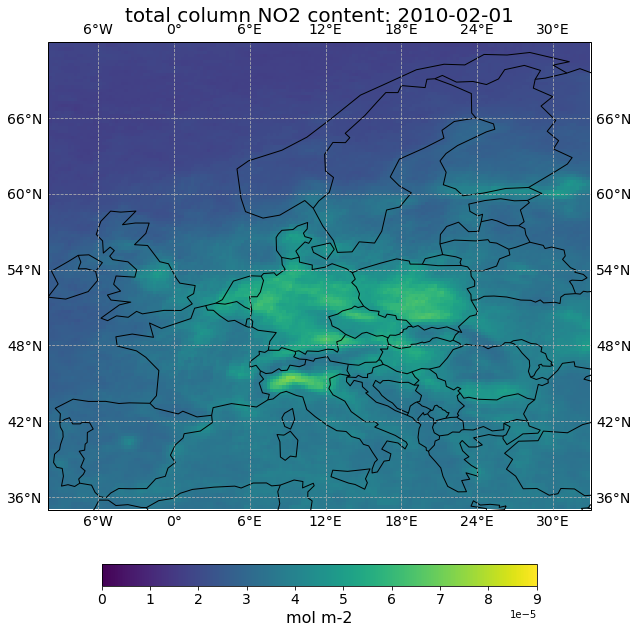

In [53]:
# Select the month to be visualised
month = 1 

visualize_pcolormesh(data_array=no2amc.isel(time=month),
                     longitude=no2amc.lon, 
                     latitude=no2amc.lat,
                     projection=ccrs.PlateCarree(), 
                     color_scale='viridis', 
                     unit= no2amc.units,
                     long_name=no2amc.long_name + ': ' + str(no2amc.time[month].dt.strftime('%Y-%m-%d').data), 
                     vmin=0, 
                     vmax=9e-05, 
                     lonmin=-10, 
                     lonmax=33, 
                     latmin=35, 
                     latmax=72,
                     set_global=False)

## Save the data cube locally

You can download the data cube locally by executing the following cell.

In [54]:
download_file = './GOME2_data.nc'
print ('Saving to: ', download_file)

output_data.to_netcdf(path=download_file)
print ('Data saved on disk!')

Saving to:  ./GOME2_data.nc
Data saved on disk!


**Note**: the dataset could be unavailable locally on your machine, but it has been indeed generated on the host machine.

## Remove all files from the target directory

To clean up the target directory at the end of the notebook, you just need to execute the cell below.

In [28]:
files_to_remove = os.listdir(target_dir)

for file in files_to_remove:
    if file.endswith(".nc") or file.endswith(".txt"):
        os.remove(os.path.join(target_dir, file))
print(os.listdir(target_dir))

['.ipynb_checkpoints', '0_Introduction_to_Data_Tailor_ACDC_plugin.ipynb', '1_Multivariable_datacube_for_atmospheric_composition_observation.ipynb', '2_Multiproduct_datacube_for_atmospheric_composition_observation.ipynb', '3_Multiplatform_datacube_for_atmospheric_composition_observation.ipynb', '4_Multisensor_multiplatform_datacube_for_atmospheric_composition_observation.ipynb']


<a href="../00_index.ipynb"><< Index</a><br>

<p><img src='../img/EUMETSAT_Logo.png' align='left' alt='Logo EUMETSAT' width='15%'></img></p>
<br clear=left>
<p style="text-align:left;">This project is licensed under the <a href="../LICENSE">MIT License</a> | 
<span style="float:right;"><a href="https://gitlab.eumetsat.int/data-tailor/acdc-notebooks">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a></p>